In [8]:
import numpy as np
import numpy.matlib
from numpy import exp, abs, sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import tensorflow as tf
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
from itertools import product

tf.keras.backend.set_floatx('float64');

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

### DATA

In [2]:
# Size of the data
train_size = 40000; # Size of the training set
test_size = 4000; # Size of the test set
calibration_size = test_size;
param_in = 7; # Input size to the neural network

K_vector = np.array([31.6, 31.8, 32.0, 32.2, 32.4, 32.6, 32.8, 33.0, 33.2])
tau_vector = np.array([1/12, 2/12, 3/12, 4/12, 5/12, 6/12, 1]) 

N1 = len(K_vector)
N2 = len(tau_vector) 

params_range = np.loadtxt('params_gridbased_with_NS.dat')
price = np.reshape(np.loadtxt('price_gridbased_with_NS.dat'), newshape = (train_size+test_size, N1, N2), order ='F')

In [3]:
# Train and test sets
params_range_train = params_range[np.arange(train_size), :] # size=[train_size, param_in]
params_range_test = params_range[train_size + np.arange(test_size), :] # size=[test_size, param_in]

price_train = price[np.arange(train_size), :, :] # size=[train_size, N1, N2]
price_test = price[train_size + np.arange(test_size), :, :] # size=[test_size, N1, N2]

# Calibration set
price_cal = price_test
params_cal = params_range_test

In [5]:
price_cal.shape

(4000, 9, 7)

In [4]:
bid_ask_spread = 0.1 # rate for the spread

price_cal_ask = price_cal*(1+bid_ask_spread)
price_cal_bid = price_cal*(1-bid_ask_spread)
price_cal_range = np.moveaxis(np.array([price_cal_bid, price_cal_ask]), 0, 3)

In [5]:
price_cal_range.shape

(4000, 9, 7, 2)

## FIRST STEP

In [9]:
# Define the neural network. There are many possibilites here.
print('Initializing model')

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(30, activation='relu');
        self.dense2 = tf.keras.layers.Dense(30, activation='relu');
        self.dense3 = tf.keras.layers.Dense(30, activation='relu')
        self.dense4 = tf.keras.layers.Dense(N1*N2, activation = None)
        self.reshape = tf.keras.layers.Reshape([N1,N2]);
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.reshape(x)
        return x

# Create an instance of the model
# Create an instance of the model
model = MyModel()

# Choose optimizer and type of loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError();

model.compile(loss = loss_object,
              optimizer = optimizer)
model.build(input_shape=(1,param_in))
model.summary()

model(tf.ones(shape = (1,param_in)));

model.load_weights('opt_weight_gridbased_dense_with_NS.h5')

Initializing model
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  240       
_________________________________________________________________
dense_1 (Dense)              multiple                  930       
_________________________________________________________________
dense_2 (Dense)              multiple                  930       
_________________________________________________________________
dense_3 (Dense)              multiple                  1953      
_________________________________________________________________
reshape (Reshape)            multiple                  0         
Total params: 4,053
Trainable params: 4,053
Non-trainable params: 0
_________________________________________________________________

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this wa

## SECOND STEP

In [40]:
# BID-ASK LOSS FUNCTION
def bid_ask_loss(price_range, price_predicted):
    '''
    Computes the bid-ask loss of the price, zero within the bounds and quadratic outside.
    
    price_range (ndarray, (batch_size, N1, N2, 2)): grid of bid and ask prices
    price_predicted (ndarray, (batch_size, N1, N2)): price predicted by the neural network
    '''
    price_bid = price_range[:,:,:,0]
    price_ask = price_range[:,:,:,1]
    
    mask_bid = price_predicted < price_bid
    mask_ask = price_predicted > price_ask
    bid_loss = tf.math.square(tf.math.subtract(price_predicted, price_bid))
    ask_loss = tf.math.square(tf.math.subtract(price_predicted, price_ask))
        
    bid_ask_loss = tf.math.reduce_sum(tf.boolean_mask(bid_loss, mask_bid))+tf.math.reduce_sum(tf.boolean_mask(ask_loss, mask_ask))
    return bid_ask_loss


def mismatched_prices_rate(price_range, price_predicted):
    '''
    Computes the percentage of prices which are not within the bid-ask contraints: 
    gives 0 if the predicted price is within the bounds and 1 if it is outside.
    
    price_range (ndarray, (batch_size, N1, N2, 2)): grid of bid and ask prices
    price_predicted (ndarray, (batch_size, N1, N2)): price predicted by the neural network
    '''

    price_bid = price_range[:,:,:,0]
    price_ask = price_range[:,:,:,1]
    price_inside_range = (price_predicted > price_bid) & (price_predicted < price_ask)
        
    return (1-np.sum(price_inside_range, axis=0)/price_predicted.shape[0])


# These are for the plots after calibration
def mask_for_plot_inside(price_bid, price_ask, price_predicted):
    
    price_outside_range = (price_predicted < price_bid) | (price_predicted > price_ask)
        
    return  np.ma.masked_where(price_outside_range, price_predicted)

def mask_for_plot_outside(price_bid, price_ask, price_predicted):
    
    price_inside_range = (price_predicted > price_bid) & (price_predicted < price_ask)
        
    return  np.ma.masked_where(price_inside_range, price_predicted)

In [10]:
# The network is done training. We are ready to start on the Calibration step
print('\n\nCalibration step')

EPOCHS_CAL = 1000     # Number of steps calebrating

# Choose optimizer and type of loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = bid_ask_loss
calibration_loss = tf.keras.metrics.Mean(name='calibration_mean')

# This does depend on the calibration size
cal_ds = tf.data.Dataset.from_tensor_slices(
              (price_cal_range)).batch(calibration_size)

print('Compiling calibration step')
@tf.function
def calibration_step(input_guess, prices):
        
        with tf.GradientTape() as tape:
            tape.watch(input_guess)
            prediction = model(input_guess)
            c_loss = loss_object(prices, prediction)
        calibration_loss(c_loss)
        grads = tape.gradient(c_loss, [input_guess])
        optimizer.apply_gradients(zip(grads, [input_guess]))

# We need to guess some initial model parameters.
input_guess = params_cal + np.random.rand(calibration_size, param_in)*np.array([0.05, 0.05, 0.5, 0.5, 0.05, 0.05, 0.05])

# I just copy the starting parameters for convenience. This is not necessary
old_input_guess = input_guess.copy();

# Important: First convert to tensor, then to variable
tf_input_guess = tf.convert_to_tensor(input_guess)
tf_var_input_guess = tf.Variable(tf_input_guess);

# Start the actual calibration
for epoch in range(EPOCHS_CAL):
    calibration_loss.reset_states()
    for labels in cal_ds:
        # For each set of labels, compute the gradient of the network, and 
        # preform a gradient update on the input parameters. 
        calibration_step(tf_var_input_guess, labels)

    template = 'Epoch_cal {}, Loss: {}'
    print(template.format(epoch+1,
                          calibration_loss.result(),
                          ))

new_input_guess = tf_var_input_guess.numpy();

X = new_input_guess-old_input_guess
print(np.linalg.norm(X, 'fro'));




Calibration step
Compiling calibration step
Epoch_cal 1, Loss: 6935.400846813748
Epoch_cal 2, Loss: 6844.6016295516965
Epoch_cal 3, Loss: 6754.659215840713
Epoch_cal 4, Loss: 6665.572299676553
Epoch_cal 5, Loss: 6577.340329681618
Epoch_cal 6, Loss: 6490.016682528894
Epoch_cal 7, Loss: 6403.595953251145
Epoch_cal 8, Loss: 6318.076936973512
Epoch_cal 9, Loss: 6233.466408614857
Epoch_cal 10, Loss: 6149.738248825352
Epoch_cal 11, Loss: 6066.901916990102
Epoch_cal 12, Loss: 5984.97362029441
Epoch_cal 13, Loss: 5903.974922051918
Epoch_cal 14, Loss: 5823.925547338533
Epoch_cal 15, Loss: 5744.782400194507
Epoch_cal 16, Loss: 5666.550976904481
Epoch_cal 17, Loss: 5589.229735584569
Epoch_cal 18, Loss: 5512.831165513983
Epoch_cal 19, Loss: 5437.35779034118
Epoch_cal 20, Loss: 5362.812804362817
Epoch_cal 21, Loss: 5289.174710929806
Epoch_cal 22, Loss: 5216.438445058616
Epoch_cal 23, Loss: 5144.599272109803
Epoch_cal 24, Loss: 5073.639620632976
Epoch_cal 25, Loss: 5003.570213427217
Epoch_cal 26, 

Epoch_cal 138, Loss: 1046.0661495288143
Epoch_cal 139, Loss: 1032.3938962447644
Epoch_cal 140, Loss: 1018.9229804226779
Epoch_cal 141, Loss: 1005.6504881737519
Epoch_cal 142, Loss: 992.5736238495958
Epoch_cal 143, Loss: 979.6895903739246
Epoch_cal 144, Loss: 966.9970559975452
Epoch_cal 145, Loss: 954.4934632588979
Epoch_cal 146, Loss: 942.1745234523095
Epoch_cal 147, Loss: 930.0397955529961
Epoch_cal 148, Loss: 918.0867368907295
Epoch_cal 149, Loss: 906.3084569361769
Epoch_cal 150, Loss: 894.7060593736888
Epoch_cal 151, Loss: 883.2750192453395
Epoch_cal 152, Loss: 872.0121457266282
Epoch_cal 153, Loss: 860.9264361911114
Epoch_cal 154, Loss: 850.0009445069064
Epoch_cal 155, Loss: 839.2367161095884
Epoch_cal 156, Loss: 828.6326741710393
Epoch_cal 157, Loss: 818.1843271818616
Epoch_cal 158, Loss: 807.8873117015331
Epoch_cal 159, Loss: 797.7435587922597
Epoch_cal 160, Loss: 787.7634715223003
Epoch_cal 161, Loss: 777.9260387018629
Epoch_cal 162, Loss: 768.2346256612725
Epoch_cal 163, Loss: 

Epoch_cal 348, Loss: 125.30065040585436
Epoch_cal 349, Loss: 124.3956409537773
Epoch_cal 350, Loss: 123.49864415895263
Epoch_cal 351, Loss: 122.60995416431692
Epoch_cal 352, Loss: 121.73245580262636
Epoch_cal 353, Loss: 120.86180537486425
Epoch_cal 354, Loss: 119.9995818111981
Epoch_cal 355, Loss: 119.1445798779659
Epoch_cal 356, Loss: 118.3024733195542
Epoch_cal 357, Loss: 117.46913967392418
Epoch_cal 358, Loss: 116.64815646971095
Epoch_cal 359, Loss: 115.83405458339341
Epoch_cal 360, Loss: 115.02805766810107
Epoch_cal 361, Loss: 114.22870948804764
Epoch_cal 362, Loss: 113.43670024574874
Epoch_cal 363, Loss: 112.65246339585148
Epoch_cal 364, Loss: 111.87519886287069
Epoch_cal 365, Loss: 111.10588324952784
Epoch_cal 366, Loss: 110.3437900954353
Epoch_cal 367, Loss: 109.58943690678397
Epoch_cal 368, Loss: 108.84699982304895
Epoch_cal 369, Loss: 108.1099704849268
Epoch_cal 370, Loss: 107.38242806771851
Epoch_cal 371, Loss: 106.65979429378612
Epoch_cal 372, Loss: 105.94323994674193
Epoch_

Epoch_cal 563, Loss: 38.30033353436842
Epoch_cal 564, Loss: 38.13910953687961
Epoch_cal 565, Loss: 37.97939623963837
Epoch_cal 566, Loss: 37.82025366729132
Epoch_cal 567, Loss: 37.66240455042683
Epoch_cal 568, Loss: 37.50562816092804
Epoch_cal 569, Loss: 37.35039065884626
Epoch_cal 570, Loss: 37.19620765449304
Epoch_cal 571, Loss: 37.042575749072995
Epoch_cal 572, Loss: 36.88911073406855
Epoch_cal 573, Loss: 36.73655863259745
Epoch_cal 574, Loss: 36.585927683873265
Epoch_cal 575, Loss: 36.43679437143372
Epoch_cal 576, Loss: 36.2882860170737
Epoch_cal 577, Loss: 36.140329574796134
Epoch_cal 578, Loss: 35.99337157930023
Epoch_cal 579, Loss: 35.847458024465034
Epoch_cal 580, Loss: 35.7019570260596
Epoch_cal 581, Loss: 35.55766470329757
Epoch_cal 582, Loss: 35.41533222528645
Epoch_cal 583, Loss: 35.27323706870193
Epoch_cal 584, Loss: 35.13185570588006
Epoch_cal 585, Loss: 34.991792468652065
Epoch_cal 586, Loss: 34.85208099518033
Epoch_cal 587, Loss: 34.7128821263353
Epoch_cal 588, Loss: 34

Epoch_cal 775, Loss: 18.066519078098608
Epoch_cal 776, Loss: 18.012259846298512
Epoch_cal 777, Loss: 17.958209934686003
Epoch_cal 778, Loss: 17.904072283025258
Epoch_cal 779, Loss: 17.849838641861822
Epoch_cal 780, Loss: 17.795860431911898
Epoch_cal 781, Loss: 17.742001990965193
Epoch_cal 782, Loss: 17.68842170623381
Epoch_cal 783, Loss: 17.63494060918697
Epoch_cal 784, Loss: 17.581547682192127
Epoch_cal 785, Loss: 17.5281250052067
Epoch_cal 786, Loss: 17.475025372573512
Epoch_cal 787, Loss: 17.422125363928522
Epoch_cal 788, Loss: 17.369761308733924
Epoch_cal 789, Loss: 17.31749613127496
Epoch_cal 790, Loss: 17.2655689081049
Epoch_cal 791, Loss: 17.213829347856734
Epoch_cal 792, Loss: 17.162154221381673
Epoch_cal 793, Loss: 17.110518891688006
Epoch_cal 794, Loss: 17.059078340620047
Epoch_cal 795, Loss: 17.007859613506874
Epoch_cal 796, Loss: 16.956912256678333
Epoch_cal 797, Loss: 16.90625395422446
Epoch_cal 798, Loss: 16.85592876870254
Epoch_cal 799, Loss: 16.805786149480035
Epoch_cal

Epoch_cal 987, Loss: 10.077423793713493
Epoch_cal 988, Loss: 10.05230978947315
Epoch_cal 989, Loss: 10.027179736264527
Epoch_cal 990, Loss: 10.002296878062499
Epoch_cal 991, Loss: 9.977467601098486
Epoch_cal 992, Loss: 9.952689966875965
Epoch_cal 993, Loss: 9.927990695411463
Epoch_cal 994, Loss: 9.9034358112606
Epoch_cal 995, Loss: 9.878980527269608
Epoch_cal 996, Loss: 9.854581445590355
Epoch_cal 997, Loss: 9.830180780608451
Epoch_cal 998, Loss: 9.80585273110343
Epoch_cal 999, Loss: 9.781579134620857
Epoch_cal 1000, Loss: 9.75741581781164
28.38370383301801


In [11]:
#np.savetxt('params_calibrated_adam_with_NS_BA.dat', new_input_guess)
new_input_guess = np.loadtxt('params_calibrated_adam_with_NS_BA.dat')

In [12]:
# Errors and plots
percentage_err = np.abs(new_input_guess-params_cal)/np.abs(params_cal)
mean_percentage_err = np.mean(percentage_err, axis = 0)*100
percentage_err_copy = percentage_err.copy()
percentage_err_copy.sort(axis=0)
median_percentage_err = percentage_err_copy[calibration_size//2, :]*100

In [13]:
mean_percentage_err

array([40.74161428, 26.01484505,  4.95407147,  0.29151158,  7.06182799,
       17.49282629,  1.56780189])

In [14]:
median_percentage_err

array([33.25366884, 21.32554043,  4.06886817,  0.3048982 ,  6.47071878,
       12.47195473,  1.36749063])

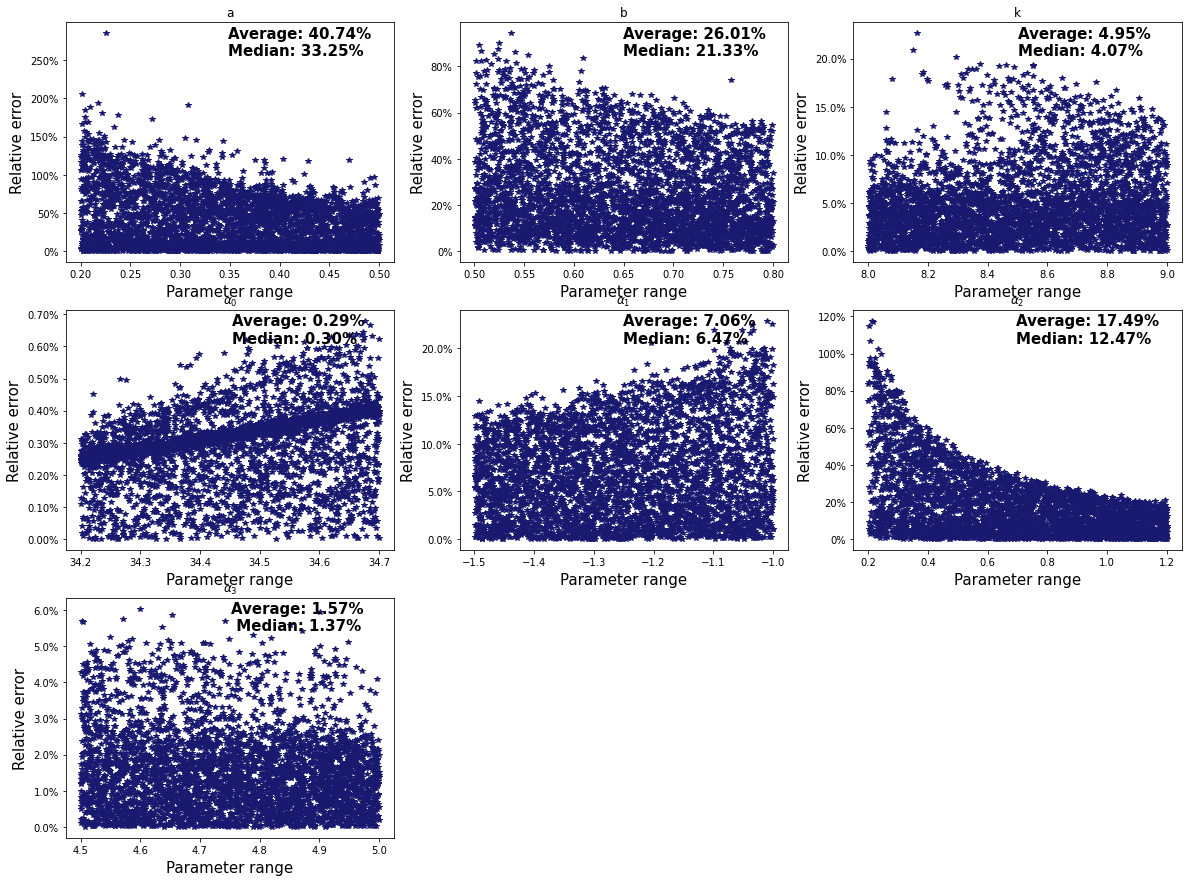

In [15]:
f = plt.figure(figsize = (20,15))
plt.subplot(3,3,1)
plt.plot(params_cal[:,0], percentage_err[:,0]*100, '*', color = 'midnightblue')
plt.title('a')
plt.ylabel('Relative error',fontsize=15,labelpad=5);
plt.xlabel('Parameter range',fontsize=15,labelpad=5);
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
s0 = 'Average: %.2f' %mean_percentage_err[0] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[0] + r'%'
plt.text(np.mean(params_cal[:,0]), np.max(percentage_err[:,0]*90), s0, fontsize=15, color = 'black', weight = 'bold')

plt.subplot(3,3,2)
plt.plot(params_cal[:,1], percentage_err[:,1]*100, '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('b')
plt.ylabel('Relative error',fontsize=15,labelpad=5);
plt.xlabel('Parameter range',fontsize=15,labelpad=5);
s1 = 'Average: %.2f' %mean_percentage_err[1] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[1] + r'%'
plt.text(np.mean(params_cal[:,1]), np.max(percentage_err[:,1]*90), s1, fontsize=15, color = 'black', weight = 'bold')

plt.subplot(3,3,3)
plt.plot(params_cal[:,2], percentage_err[:,2]*100, '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('k')
plt.ylabel('Relative error',fontsize=15,labelpad=5);
plt.xlabel('Parameter range',fontsize=15,labelpad=5);
s2 = 'Average: %.2f' %mean_percentage_err[2] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[2] + r'%'
plt.text(np.mean(params_cal[:,2]), np.max(percentage_err[:,2]*90), s2, fontsize=15, color = 'black', weight = 'bold')

plt.subplot(3,3,4)
plt.plot(params_cal[:,3], percentage_err[:,3]*100, '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_0$')
plt.ylabel('Relative error',fontsize=15,labelpad=5);
plt.xlabel('Parameter range',fontsize=15,labelpad=5);
s2 = 'Average: %.2f' %mean_percentage_err[3] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[3] + r'%'
plt.text(np.mean(params_cal[:,3]), np.max(percentage_err[:,3]*90), s2, fontsize=15, color = 'black', weight = 'bold')

plt.subplot(3,3,5)
plt.plot(params_cal[:,4], percentage_err[:,4]*100, '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_1$')
plt.ylabel('Relative error',fontsize=15,labelpad=5);
plt.xlabel('Parameter range',fontsize=15,labelpad=5);
s2 = 'Average: %.2f' %mean_percentage_err[4] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[4] + r'%'
plt.text(np.mean(params_cal[:,4]), np.max(percentage_err[:,4]*90), s2, fontsize=15, color = 'black', weight = 'bold')

plt.subplot(3,3,6)
plt.plot(params_cal[:,5], percentage_err[:,5]*100, '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_2$')
plt.ylabel('Relative error',fontsize=15,labelpad=5);
plt.xlabel('Parameter range',fontsize=15,labelpad=5);
s2 = 'Average: %.2f' %mean_percentage_err[5] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[5] + r'%'
plt.text(np.mean(params_cal[:,5]), np.max(percentage_err[:,5]*90), s2, fontsize=15, color = 'black', weight = 'bold')

plt.subplot(3,3,7)
plt.plot(params_cal[:,6], percentage_err[:,6]*100,'*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_3$')
plt.ylabel('Relative error',fontsize=15,labelpad=5);
plt.xlabel('Parameter range',fontsize=15,labelpad=5);
s2 = 'Average: %.2f' %mean_percentage_err[6] + r'%' +' \n '+ 'Median: %.2f' %median_percentage_err[6] + r'%'
plt.text(np.mean(params_cal[:,6]), np.max(percentage_err[:,6]*90), s2, fontsize=15, color = 'black', weight = 'bold');

#f.savefig('cal_gridbased_dense_with_NS_BA.pdf', bbox_inches = 'tight', pad_inches = 0.01)

In [16]:
start_input_guess = old_input_guess
price_predicted_start = model(start_input_guess).numpy()

price_predicted_cal = model(new_input_guess).numpy()

err_training_cal =  mismatched_prices_rate(price_cal_range, price_predicted_cal)*100
err_training_start =  mismatched_prices_rate(price_cal_range, price_predicted_start)*100

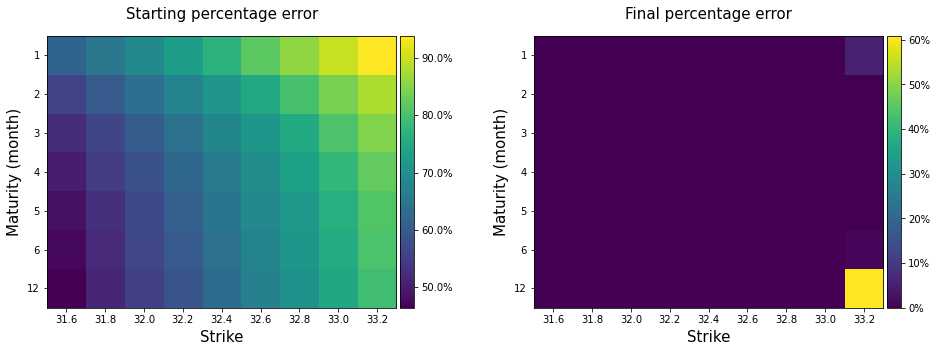

In [17]:
K_label = np.array([31.6, 31.8, 32.0, 32.2, 32.4, 32.6, 32.8, 33.0, 33.2])
tau_label = ['1', '2', '3', '4', '5', '6', '12']

f = plt.figure(1,figsize=(16,5))
ax = plt.subplot(1,2,1)
plt.title("Starting percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(err_training_start))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_label)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

ax = plt.subplot(1,2,2)
plt.title("Final percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(err_training_cal))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_label)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

#f.savefig('error_step2_gridbased_dense_with_NS_BA.pdf', bbox_inches = 'tight', pad_inches = 0.01)

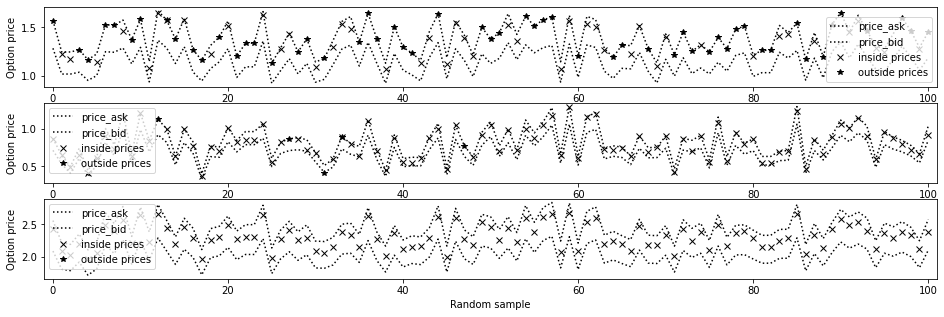

In [41]:
N_plt = 100
x = np.sort(np.random.randint(low = 0, high = calibration_size, size = N_plt+1))

f = plt.figure(figsize=(16, 5))
plt.subplot(3,1,1)
j = 8
k = 6
inside = mask_for_plot_inside(price_cal_range[x,j,k, 0], price_cal_range[x,j,k, 1], price_predicted_cal[x,j,k])
outside = mask_for_plot_outside(price_cal_range[x,j,k, 0], price_cal_range[x,j,k, 1], price_predicted_cal[x,j,k])
plt.plot(np.arange(N_plt+1), price_cal_range[x,j,k, 0], ':k')
plt.plot(np.arange(N_plt+1), price_cal_range[x,j,k, 1], ':k')
plt.plot(np.arange(N_plt+1), inside, 'xk')
plt.plot(np.arange(N_plt+1), outside, '*k')
plt.ylabel('Option price')
plt.xlabel('Random sample')
plt.xlim([-1, N_plt+1])
plt.legend(['price_ask', 'price_bid', 'inside prices', 'outside prices'])

plt.subplot(3,1,2)
j = 8
k = 0
inside = mask_for_plot_inside(price_cal_range[x,j,k, 0], price_cal_range[x,j,k, 1], price_predicted_cal[x,j,k])
outside = mask_for_plot_outside(price_cal_range[x,j,k, 0], price_cal_range[x,j,k, 1], price_predicted_cal[x,j,k])
plt.plot(np.arange(N_plt+1), price_cal_range[x,j,k, 0], ':k')
plt.plot(np.arange(N_plt+1), price_cal_range[x,j,k, 1], ':k')
plt.plot(np.arange(N_plt+1), inside, 'xk')
plt.plot(np.arange(N_plt+1), outside, '*k')
plt.ylabel('Option price')
plt.xlabel('Random sample')
plt.xlim([-1, N_plt+1])
plt.legend(['price_ask', 'price_bid', 'inside prices', 'outside prices'])

plt.subplot(3,1,3)
j = 3
k = 3
inside = mask_for_plot_inside(price_cal_range[x,j,k, 0], price_cal_range[x,j,k, 1], price_predicted_cal[x,j,k])
outside = mask_for_plot_outside(price_cal_range[x,j,k, 0], price_cal_range[x,j,k, 1], price_predicted_cal[x,j,k])
plt.plot(np.arange(N_plt+1), price_cal_range[x,j,k, 0], ':k')
plt.plot(np.arange(N_plt+1), price_cal_range[x,j,k, 1], ':k')
plt.plot(np.arange(N_plt+1), inside, 'xk')
plt.plot(np.arange(N_plt+1), outside, '*k')
plt.ylabel('Option price')
plt.xlabel('Random sample')
plt.xlim([-1, N_plt+1])
plt.legend(['price_ask', 'price_bid', 'inside prices', 'outside prices']);

#f.savefig('bid_ask_gridbased_dense_with_NS.pdf', bbox_inches = 'tight', pad_inches = 0.01)